# README

TODO

# Libraries

In [72]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [73]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'InversionExp_Characteristics'
data_file = 'MC_DATA'
exp_date = '07Feb24'
run_head = 'trueStart'

SNR_value = 500
var_reps = 1000

add_tag = ""

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
ParamTitle_4p = [r'$d_1$', r'$d_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [74]:
with open(f'{cwd_full}{base_file}/{exp_file}/{data_file}/hprParameter_{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    check_SNR_value = dict['SNR_value']
    TI_DATA = dict['TI_DATA']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    check_var_reps = dict["var_reps"]
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

assert(SNR_value == check_SNR_value)
assert(check_var_reps == var_reps)

# Functions

In [75]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_TI = np.stack(df["TI"].values) #shape: 
    ALL_TD_params = np.stack(df["TD_params"].values) #shape: 
    ALL_OD_params = np.stack(df["OD_params"].values) #shape: 
    ALL_TD_RSS = np.stack(df["TD_RSS"].values) #shape: 
    ALL_OD_RSS = np.stack(df["OD_RSS"].values) #shape:
    ALL_NR = np.stack(df["NR"].values) #shape:

    return ALL_TI, ALL_TD_params, ALL_OD_params, ALL_TD_RSS, ALL_OD_RSS, ALL_NR

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [76]:
def prepare_data():
    # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    TD_params_ordered = np.zeros((len(TI_DATA), var_reps, 6))
    OD_params_ordered = np.zeros((len(TI_DATA), var_reps, 4))
    TD_RSS_ordered = np.zeros((len(TI_DATA), var_reps))
    OD_RSS_ordered = np.zeros((len(TI_DATA), var_reps))
    
    data_name = f"{cwd_full}{base_file}/{exp_file}/{data_file}/{run_head}_SNR{SNR_value}_iter{var_reps}_{add_tag}{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    TI, TD_params, OD_params, TD_RSS, OD_RSS, NR = to_readable_2DWindow(data_name)

    for index in range(len(TI)):

        temp_TI = TI[index]

        TI_index = np.where(temp_TI==TI_DATA)[0][0]

        nr_index = NR[index]

        TD_params_ordered[TI_index,nr_index,:] = TD_params[index,:]
        OD_params_ordered[TI_index,nr_index,:] = OD_params[index,:]
        TD_RSS_ordered[TI_index,nr_index] = TD_RSS[index]
        OD_RSS_ordered[TI_index,nr_index] = OD_RSS[index]

    return TD_params_ordered, OD_params_ordered, TD_RSS_ordered, OD_RSS_ordered

# Data Organization

In [77]:
TD_p_array, OD_p_array, TD_RSS_array, OD_RSS_array = prepare_data()


Retrieving data for /home/hamptong2/Stabilization/InversionExp_Characteristics/MC_DATA/trueStart_SNR500_iter1000_07Feb24.pkl


# Metrics of Fit

In [78]:
TD_bias = np.mean(TD_p_array, axis = 1) - true_params
TD_var = np.var(TD_p_array, axis = 1)
TD_std = np.std(TD_p_array, axis = 1)
TD_MSE = TD_bias**2 + TD_var

OD_true_params = [[d_value(iTI, c1, T11),d_value(iTI, c2, T12), T21, T22] for iTI in TI_DATA]
OD_bias = np.mean(OD_p_array, axis = 1) - OD_true_params
OD_var = np.var(OD_p_array, axis = 1)
OD_std = np.std(OD_p_array, axis = 1)
OD_MSE = OD_bias**2 + OD_var

# Figures

### Standard Deviation

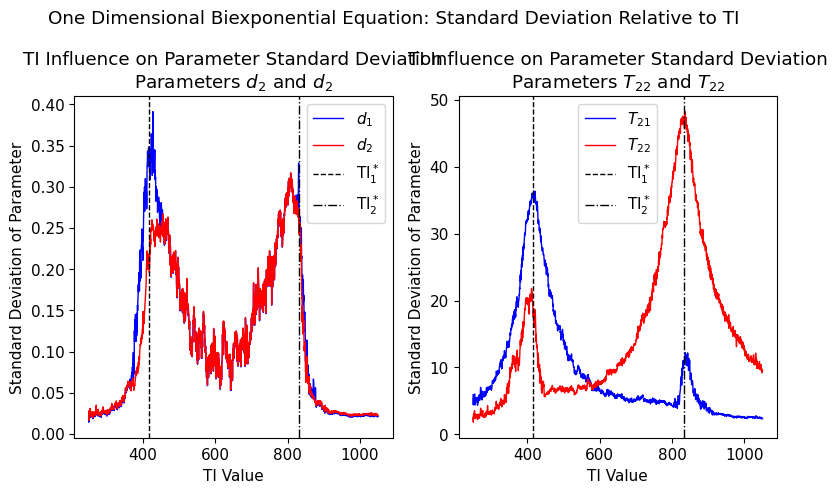

In [79]:
fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('One Dimensional Biexponential Equation: Standard Deviation Relative to TI')
for i in range(2):
    ax[i].plot(TI_DATA, OD_std[:,2*i], linewidth=1, label= ParamTitle_4p[2*i], color='b')
    ax[i].plot(TI_DATA, OD_std[:,2*i+1], linewidth=1, label= ParamTitle_4p[2*i+1], color='r')
    ax[i].axvline(TI1star, linewidth=1, label= r'TI$_1^*$', color='k', ls = '--')
    ax[i].axvline(TI2star, linewidth=1, label= r'TI$_2^*$', color='k', ls = '-.')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Standard Deviation of Parameter')
    ax[i].set_title(f'TI Influence on Parameter Standard Deviation\nParameters {ParamTitle_4p[2*i+1]} and {ParamTitle_4p[2*i+1]}')
    ax[i].legend()
plt.show()

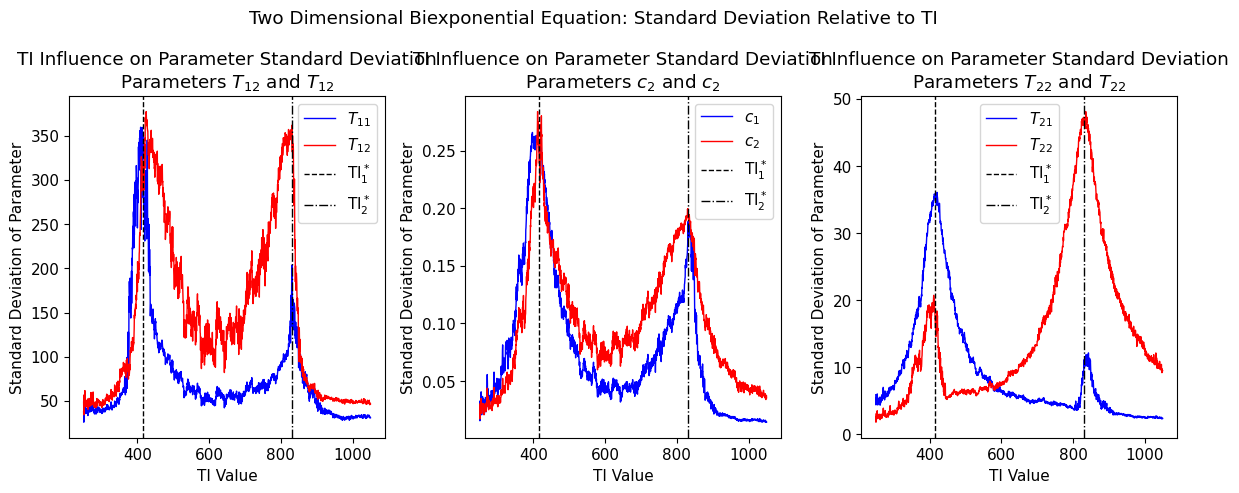

In [80]:
fig, ax = plt.subplots(1,3, figsize=(12,5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('Two Dimensional Biexponential Equation: Standard Deviation Relative to TI')
for i in range(3):
    ax[i].plot(TI_DATA, TD_std[:,2*i], linewidth=1, label= ParamTitle_6p[2*i], color='b')
    ax[i].plot(TI_DATA, TD_std[:,2*i+1], linewidth=1, label= ParamTitle_6p[2*i+1], color='r')
    ax[i].axvline(TI1star, linewidth=1, label= r'TI$_1^*$', color='k', ls = '--')
    ax[i].axvline(TI2star, linewidth=1, label= r'TI$_2^*$', color='k', ls = '-.')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Standard Deviation of Parameter')
    ax[i].set_title(f'TI Influence on Parameter Standard Deviation\nParameters {ParamTitle_6p[2*i+1]} and {ParamTitle_6p[2*i+1]}')
    ax[i].legend()
plt.show()

### Bias

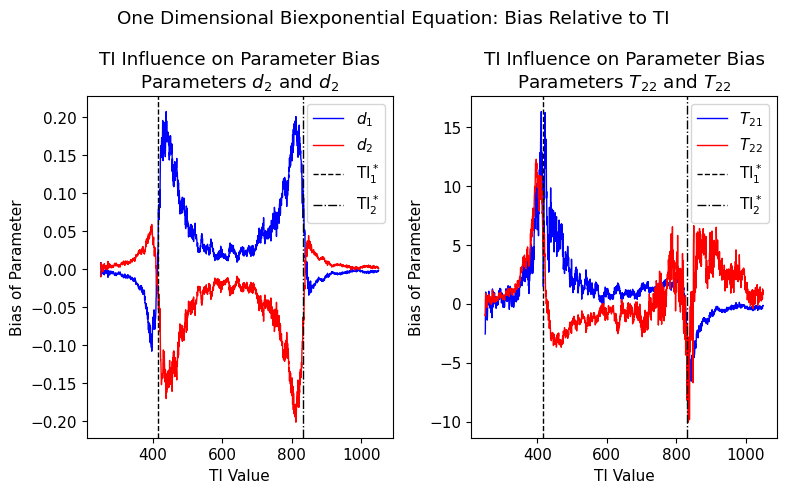

In [81]:
fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('One Dimensional Biexponential Equation: Bias Relative to TI')
for i in range(2):
    ax[i].plot(TI_DATA, OD_bias[:,2*i], linewidth=1, label= ParamTitle_4p[2*i], color='b')
    ax[i].plot(TI_DATA, OD_bias[:,2*i+1], linewidth=1, label= ParamTitle_4p[2*i+1], color='r')
    ax[i].axvline(TI1star, linewidth=1, label= r'TI$_1^*$', color='k', ls = '--')
    ax[i].axvline(TI2star, linewidth=1, label= r'TI$_2^*$', color='k', ls = '-.')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Bias of Parameter')
    ax[i].set_title(f'TI Influence on Parameter Bias\nParameters {ParamTitle_4p[2*i+1]} and {ParamTitle_4p[2*i+1]}')
    ax[i].legend()
plt.show()

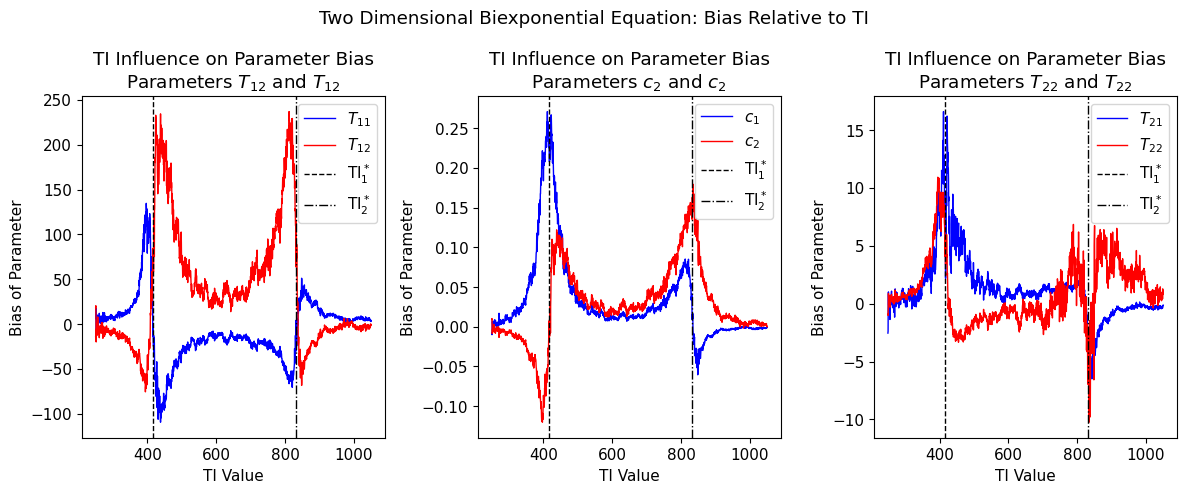

In [82]:
fig, ax = plt.subplots(1,3, figsize=(12,5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('Two Dimensional Biexponential Equation: Bias Relative to TI')
for i in range(3):
    ax[i].plot(TI_DATA, TD_bias[:,2*i], linewidth=1, label= ParamTitle_6p[2*i], color='b')
    ax[i].plot(TI_DATA, TD_bias[:,2*i+1], linewidth=1, label= ParamTitle_6p[2*i+1], color='r')
    ax[i].axvline(TI1star, linewidth=1, label= r'TI$_1^*$', color='k', ls = '--')
    ax[i].axvline(TI2star, linewidth=1, label= r'TI$_2^*$', color='k', ls = '-.')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Bias of Parameter')
    ax[i].set_title(f'TI Influence on Parameter Bias\nParameters {ParamTitle_6p[2*i+1]} and {ParamTitle_6p[2*i+1]}')
    ax[i].legend()
plt.show()

### MSE

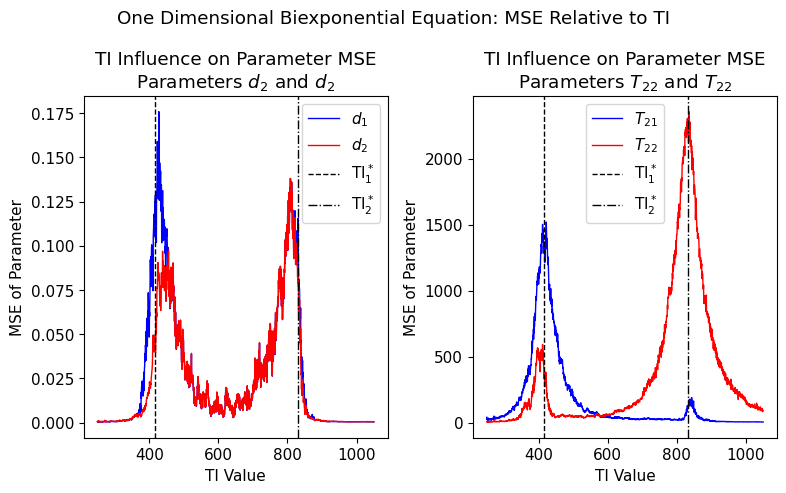

In [83]:
fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('One Dimensional Biexponential Equation: MSE Relative to TI')
for i in range(2):
    ax[i].plot(TI_DATA, OD_MSE[:,2*i], linewidth=1, label= ParamTitle_4p[2*i], color='b')
    ax[i].plot(TI_DATA, OD_MSE[:,2*i+1], linewidth=1, label= ParamTitle_4p[2*i+1], color='r')
    ax[i].axvline(TI1star, linewidth=1, label= r'TI$_1^*$', color='k', ls = '--')
    ax[i].axvline(TI2star, linewidth=1, label= r'TI$_2^*$', color='k', ls = '-.')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('MSE of Parameter')
    ax[i].set_title(f'TI Influence on Parameter MSE\nParameters {ParamTitle_4p[2*i+1]} and {ParamTitle_4p[2*i+1]}')
    ax[i].legend()
plt.show()

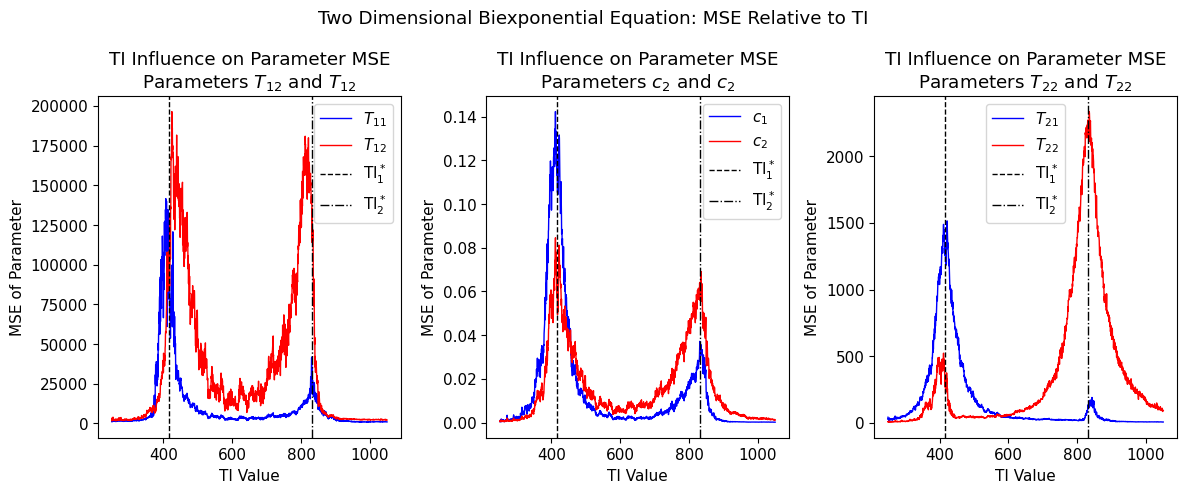

In [84]:
fig, ax = plt.subplots(1,3, figsize=(12,5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle('Two Dimensional Biexponential Equation: MSE Relative to TI')
for i in range(3):
    ax[i].plot(TI_DATA, TD_MSE[:,2*i], linewidth=1, label= ParamTitle_6p[2*i], color='b')
    ax[i].plot(TI_DATA, TD_MSE[:,2*i+1], linewidth=1, label= ParamTitle_6p[2*i+1], color='r')
    ax[i].axvline(TI1star, linewidth=1, label= r'TI$_1^*$', color='k', ls = '--')
    ax[i].axvline(TI2star, linewidth=1, label= r'TI$_2^*$', color='k', ls = '-.')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('MSE of Parameter')
    ax[i].set_title(f'TI Influence on Parameter MSE\nParameters {ParamTitle_6p[2*i+1]} and {ParamTitle_6p[2*i+1]}')
    ax[i].legend()
plt.show()